In [1]:
import sys
sys.path.append("..")

In [12]:
from squlearn.observables import SummedPaulis
from squlearn.qnn import QNNRegressor
from squlearn.qnn.lowlevel_qnn import LowLevelQNN
from squlearn.optimizers import Adam
from squlearn.qnn.loss import ODELoss
from squlearn.qnn.training import *
from squlearn.encoding_circuit import *
import numpy as np
import matplotlib.pyplot as plt
from circuits.circuits import SimpleAnalyticalCircuit

In [13]:
#Our function assume that the input is a tensor of shape (n, 4) where n is the number of points, each entry corresponds to 
#x, f, dfdx and dfdxdx as shown below
def loss_harmonic_oscillator(f_alpha_tensor):
    """
    Args:
        f_array (np.array): array of shape (n, 4) where n is the number of points, each entry corresponds to 
    x, f, dfdx and dfdxdx. This is: f_array = [x, f, dfdx, dfdxdx]
    Returns:
    loss (np.array): array of shape [F] where F is the loss function
    """
    x, f, dfdx, dfdxdx = f_alpha_tensor
    k=1

    return dfdxdx + k*f

def grad_loss_harmonic_oscillator(f_alpha_tensor):
    """
    Args:
        f_array (np.array): array of shape (n, 4) where n is the number of points, each entry corresponds to 
    x, f, dfdx and dfdxdx. This is: f_array = [x, f, dfdx, dfdxdx]
    Returns:
        grad_loss (np.array): array of shape [dFdf, dFdfdx, dFdfdxdx] 
    where dFdf is the derivative of the loss function with respect to f, dFdfdx is the derivative of the loss function with respect to dfdx and dFdfdxdx is the derivative of the loss function with respect to dfdxdx
    """
    x, f, dfdx, dfdxdx = f_alpha_tensor
    k = 1
    return [k, 0, 1]

In [14]:
x_line = np.linspace(-0.9, 0.9, 15) #x domain to solve the ODE
k = 1

f_initial = [np.cos(np.sqrt(k)*x_line[0]), -np.sin(np.sqrt(k)*x_line[0])] #Initial condition for the ODE
#Exact result
f_exact = np.cos(np.sqrt(k)*x_line)

In [25]:
num_qubits = 1
num_features = 1
num_layers = 2
circuit = SimpleAnalyticalCircuit(num_qubits, num_features, num_layers)
#circuit = ChebyshevPQC(num_qubits, num_features, num_layers)
executor = Executor("pennylane")

Observables = SummedPaulis(num_qubits, include_identity=False)                                                      
param_obs = Observables.generate_initial_parameters(seed=1)
param_ini = circuit.generate_initial_parameters(seed=1)

adam = Adam(options={"maxiter": 20, "tol": 0.00009, "log_file": "SHO_DE.log", "skip_mse_fun":False, "lr":0.1})
loss_ODE = ODELoss(loss_harmonic_oscillator, grad_loss_harmonic_oscillator, initial_vec = f_initial, eta=1, true_solution = f_exact)


ode_regressor = QNNRegressor(
    circuit,
    Observables,
    executor,
    loss_ODE,
    adam,
    param_ini,
    param_obs,
    opt_param_op = False, #Parametrized Observables not benchmarked yet
)


In [26]:
ode_regressor.fit(x_line, np.zeros((x_line.shape[0])),  weights=None)
f_QNN = ode_regressor.predict(x_line)

fit: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


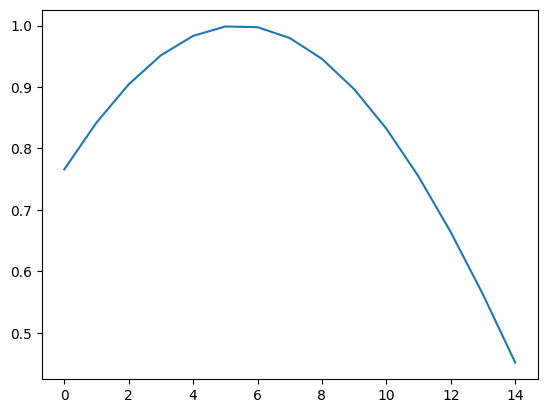

In [27]:
plt.plot(f_QNN)